In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2



# Phase 1 Comparison

In [2]:
# load the data
root = os.path.dirname(os.getcwd())
data_dir = os.path.join(root, "data")
# files = {
#     "long": {
#         "lymphoma": [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" in file],
#         "oncology": [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" in file]
#     },
#     "clinicalai": {
#         "lymphoma": [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" not in file and "csv" in file],
#         "oncology": [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase" in file and "csv" in file]
#     }
#     }
# files

In [3]:
files = {
    "long": {
        "lymphoma":{
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" in file] if "test" in x)
        },
        "oncology": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" in file] if "test" in x)
        }
    },
    "clinicalai":{
        "lymphoma phase1": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" not in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" not in file and "csv" in file] if "test" in x)
        },
        "oncology phase1": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase1" in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase1" in file and "csv" in file] if "test" in x)
        },
        "oncology phase2": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase2" in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase2" in file and "csv" in file] if "test" in x)
        },
        "oncology phase3": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase3" in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase3" in file and "csv" in file] if "test" in x)
        }

    }
}

files

{'long': {'lymphoma': {'train': 'long_cleaned_data_phase1_lymph_2bin_train.csv',
   'test': 'long_cleaned_data_phase1_lungc_2bin_test.csv'},
  'oncology': {'train': 'long_cleaned_data_phase1_oncol_2bin_train.csv',
   'test': 'long_cleaned_data_phase1_oncol_2bin_test.csv'}},
 'clinicalai': {'lymphoma phase1': {'train': 'cleaned_data_phase1_lymph_2bin_train.csv',
   'test': 'cleaned_data_phase1_lungc_2bin_test.csv'},
  'oncology phase1': {'train': 'cleaned_data_phase1_2bin_train.csv',
   'test': 'cleaned_data_phase1_2bin_test.csv'},
  'oncology phase2': {'train': 'cleaned_data_phase2_2bin_train.csv',
   'test': 'cleaned_data_phase2_2bin_test.csv'},
  'oncology phase3': {'train': 'cleaned_data_phase3_2bin_train.csv',
   'test': 'cleaned_data_phase3_2bin_test.csv'}}}

In [4]:
def train_and_retrain_model(model_type, data, train_data, drop_cols, root, model_class):
    # file = [file for file in train_data[model_type][data] if "train" in file]
    file = train_data[model_type][data]["train"]
    df = pd.read_csv(os.path.join(root, "data", file))

    y_cols = ["study_eq_labels"]

    X = df.drop(columns=y_cols+drop_cols)
    features = X.columns
    y = df[y_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_class == 'rf':
        model = RandomForestClassifier()

        param_grid = {
        'n_estimators': [100, 200, 300],      # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt']      # Number of features to consider at each split
        }
    elif model_class == 'xgb':
        model = xgb.XGBClassifier()

        param_grid = {
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators': [50, 100, 200]
        }
    elif model_class == 'lgb':
        model = lgb.LGBMClassifier()

        param_grid = {
            'num_leaves': [20, 30, 40],
            'learning_rate': [0.05, 0.1],
            'n_estimators': [50, 100, 200]
        }


    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    # Predict probabilities for each class
    y_pred_prob = best_model.predict_proba(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1) + 1

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

    # get the phase
    pattern = r"(phase\d+)"
    match = re.search(pattern, file)

    # data
    data = {
        "data": file,
        "phase": match.group(1) if match else np.nan,
        "key": f"{model_type}_{data}_{model_class}",
        "model": model_class,
        "accuracy": acc,
        "kfold mean accuracy": cv_results.mean(),
        "kfold stdev accuracy": cv_results.std(),
        "mae": mae,
        "precision": pre
    }

    data_df = pd.DataFrame([data])
    display(data_df)

    return best_model, data_df, features

In [5]:
def eval_model(model_type, data, train_data, drop_cols, root):
    file = train_data[model_type][data]["test"]
    model = train_data[model_type][data]["model"]
    df = pd.read_csv(os.path.join(root, "data", file))

    y_cols = ["study_eq_labels"]

    X = df.drop(columns=y_cols+drop_cols)
    y = df[y_cols]
    
    if isinstance(model, list):
        dfs = []
        for i in model:
            for j in i:
                y_pred = i[j].predict(X)
                acc = accuracy_score(y, y_pred)
                pre = precision_score(y, y_pred, average='weighted')
                mae = mean_absolute_error(y, y_pred)

                # get the phase
                pattern = r"(phase\d+)"
                match = re.search(pattern, file)

                temp_data = {
                    "data": file,
                    "phase":  match.group(1) if match else np.nan,
                    "model": model_type,
                    "model type": j,
                    "key": f"{model_type}_{data}_{j}",
                    "accuracy": acc,
                    "mae": mae,
                    "precision": pre
                }
                temp_df = pd.DataFrame(temp_data, index=[0])
                dfs.append(temp_df)
        data_df = pd.concat(dfs)
    display(data_df)

    return data_df

# Train the models

In [6]:
train_results = []

model_classes = ['rf', 'xgb', 'lgb']

features_dict = {"long": {},
                  "clinicalai": {}}


for i in files:
    for j in files[i]:
        saved_models = []
        if i == "long":
            drop_cols = ['study_duration_days', 'study_eq_bins']
            best_model, results, features = train_and_retrain_model(model_type=i, data=j, train_data=files,
                                             drop_cols=drop_cols,
                                             root=root,
                                             model_class='rf')
            files[i][j]["model"] = [{"rf": best_model}]
            features_dict[i][j] = features
            train_results.append(results)
        elif i == "clinicalai":
            for k in model_classes:
                drop_cols = ['protocolSection_identificationModule_nctId',
                            'primary_study_duration_days', 
                            'study_duration_days',
                            'primary_eq_bins',
                            'study_eq_bins',
                            'primary_eq_labels',
                ]
                best_model, results, features = train_and_retrain_model(model_type=i, data=j, train_data=files,
                                        drop_cols=drop_cols,
                                        root=root,
                                        model_class=k)
                train_results.append(results)
                saved_models.append({k: best_model})
            files[i][j]["model"] = saved_models
            features_dict[i][j] = features

train_df = pd.concat(train_results)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,long_cleaned_data_phase1_lymph_2bin_train.csv,phase1,long_lymphoma_rf,rf,0.189573,0.681562,0.023833,0.924171,0.120018


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,long_cleaned_data_phase1_oncol_2bin_train.csv,phase1,long_oncology_rf,rf,0.708215,0.696633,0.01229,0.291785,0.708912


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_lymph_2bin_train.csv,phase1,clinicalai_lymphoma phase1_rf,rf,0.101064,0.73617,0.009866,1.053191,0.082501


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_lymph_2bin_train.csv,phase1,clinicalai_lymphoma phase1_xgb,xgb,0.106383,0.726596,0.029635,1.021277,0.081833


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952
[LightGBM] [Info] Start training from score 0.029952
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFro

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of u

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506645 -> initscore=0.026580
[LightGBM] [Info] Start training from score 0.026580
[LightGBM] [Info] Number of positive: 304, number of negative: 297
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 304, number of negative: 297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952
[LightGBM] [Info] Start training from score 0.029952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 304, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505824 -> initscore=0.023296
[LightGBM] [Info] Start training from score 0.023296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952
[LightGBM] [Info] Start training from score 0.029952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs

[LightGBM] [Info] Number of positive: 381, number of negative: 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 752, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506649 -> initscore=0.026597
[LightGBM] [Info] Start training from score 0.026597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 369, number of negative: 383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 752, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490691 -> initscore=-0.037238
[LightGBM] [Info] Start training from score -0.037238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_lymph_2bin_train.csv,phase1,clinicalai_lymphoma phase1_lgb,lgb,0.079787,0.734043,0.027537,1.042553,0.06383


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_2bin_train.csv,phase1,clinicalai_oncology phase1_rf,rf,0.136364,0.728264,0.013066,1.0,0.138953


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_2bin_train.csv,phase1,clinicalai_oncology phase1_xgb,xgb,0.141066,0.707877,0.007454,0.982759,0.138909


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choos

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 2549, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505296 -> initscore=0.021186
[LightGBM] [Info] Start training from score 0.021186


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 2549, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505296 -> initscore=0.021186
[LightGBM] [Info] Start training from score 0.021186


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 2549, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505296 -> initscore=0.021186
[LightGBM] [Info] Start training from score 0.021186


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 2550, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505098 -> initscore=0.020393
[LightGBM] [Info] Start training from score 0.020393


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 2550, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505098 -> initscore=0.020393
[LightGBM] [Info] Start training from score 0.020393


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 2550, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505098 -> initscore=0.020393
[LightGBM] [Info] Start training from score 0.020393


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_2bin_train.csv,phase1,clinicalai_oncology phase1_lgb,lgb,0.142633,0.733286,0.009656,0.974922,0.138337


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase2_2bin_train.csv,phase2,clinicalai_oncology phase2_rf,rf,0.142084,0.708796,0.015485,0.998647,0.167158


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase2_2bin_train.csv,phase2,clinicalai_oncology phase2_xgb,xgb,0.138024,0.695264,0.021556,0.997294,0.161905


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Boost

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs

[LightGBM] [Info] Number of positive: 1516, number of negative: 1440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512855 -> initscore=0.051432
[LightGBM] [Info] Start training from score 0.051432
[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518606 -> initscore=0.074459
[LightGBM] [Info] Start training from score 0.074459


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518606 -> initscore=0.074459
[LightGBM] [Info] Start training from score 0.074459


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518606 -> initscore=0.074459
[LightGBM] [Info] Start training from score 0.074459


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1532, number of negative: 1424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518268 -> initscore=0.073104
[LightGBM] [Info] Start training from score 0.073104


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase2_2bin_train.csv,phase2,clinicalai_oncology phase2_lgb,lgb,0.140731,0.710961,0.012,0.976996,0.158124


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase3_2bin_train.csv,phase3,clinicalai_oncology phase3_rf,rf,0.123711,0.765979,0.023644,0.979381,0.123711


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase3_2bin_train.csv,phase3,clinicalai_oncology phase3_xgb,xgb,0.128866,0.742268,0.024613,0.969072,0.126314


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 306, number of negative: 314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493548 -> initscore=-0.025808
[LightGBM] [Info] Start training from score -0.025808
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of u

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494364 -> initscore=-0.022545
[LightGBM] [Info] Start training from score -0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bins 636

[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493548 -> initscore=-0.025808
[LightGBM] [Info] Start training from score -0.025808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494364 -> initscore=-0.022545
[LightGBM] [Info] Start training from score -0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 306, number of negative: 314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493548 -> initscore=-0.025808
[LightGBM] [Info] Start training from score -0.025808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs

[LightGBM] [Info] Number of positive: 385, number of negative: 391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496134 -> initscore=-0.015464
[LightGBM] [Info] Start training from score -0.015464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 386, number of negative: 390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,data,phase,key,model,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase3_2bin_train.csv,phase3,clinicalai_oncology phase3_lgb,lgb,0.14433,0.738144,0.011007,0.953608,0.137391


In [7]:
df_list = []
for i in files:
    for j in files[i]:
        if i == "long":
            drop_cols = ['study_duration_days', 'study_eq_bins']
            results = eval_model(model_type=i, data=j, train_data=files,
                                             drop_cols=drop_cols,
                                             root=root,
                                             )
            df_list.append(results)
        elif i == "clinicalai":
            drop_cols = ['protocolSection_identificationModule_nctId',
                         'primary_study_duration_days', 
                         'study_duration_days',
                         'primary_eq_bins',
                         'study_eq_bins',
                         'primary_eq_labels',
            ]
            results = eval_model(model_type=i, data=j, train_data=files,
                                    drop_cols=drop_cols,
                                    root=root,
                                    )
            df_list.append(results)

final_df = pd.concat(df_list)

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,model,model type,key,accuracy,mae,precision
0,long_cleaned_data_phase1_lungc_2bin_test.csv,phase1,long,rf,long_lymphoma_rf,0.675204,0.32596,0.669687


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,model,model type,key,accuracy,mae,precision
0,long_cleaned_data_phase1_oncol_2bin_test.csv,phase1,long,rf,long_oncology_rf,0.717593,0.283069,0.715473


,data,phase,model,model type,key,accuracy,mae,precision
0,cleaned_data_phase1_lungc_2bin_test.csv,phase1,clinicalai,rf,clinicalai_lymphoma phase1_rf,0.660140,0.339860,0.660616
0,cleaned_data_phase1_lungc_2bin_test.csv,phase1,clinicalai,xgb,clinicalai_lymphoma phase1_xgb,0.665734,0.334266,0.666861
0,cleaned_data_phase1_lungc_2bin_test.csv,phase1,clinicalai,lgb,clinicalai_lymphoma phase1_lgb,0.685315,0.314685,0.686720


,data,phase,model,model type,key,accuracy,mae,precision
0,cleaned_data_phase1_2bin_test.csv,phase1,clinicalai,rf,clinicalai_oncology phase1_rf,0.748170,0.251830,0.748023
0,cleaned_data_phase1_2bin_test.csv,phase1,clinicalai,xgb,clinicalai_oncology phase1_xgb,0.748902,0.251098,0.748884
0,cleaned_data_phase1_2bin_test.csv,phase1,clinicalai,lgb,clinicalai_oncology phase1_lgb,0.740849,0.259151,0.741215


,data,phase,model,model type,key,accuracy,mae,precision
0,cleaned_data_phase2_2bin_test.csv,phase2,clinicalai,rf,clinicalai_oncology phase2_rf,0.720328,0.279672,0.720481
0,cleaned_data_phase2_2bin_test.csv,phase2,clinicalai,xgb,clinicalai_oncology phase2_xgb,0.728535,0.271465,0.728645
0,cleaned_data_phase2_2bin_test.csv,phase2,clinicalai,lgb,clinicalai_oncology phase2_lgb,0.719697,0.280303,0.719834


,data,phase,model,model type,key,accuracy,mae,precision
0,cleaned_data_phase3_2bin_test.csv,phase3,clinicalai,rf,clinicalai_oncology phase3_rf,0.730769,0.269231,0.731646
0,cleaned_data_phase3_2bin_test.csv,phase3,clinicalai,xgb,clinicalai_oncology phase3_xgb,0.750000,0.250000,0.750489
0,cleaned_data_phase3_2bin_test.csv,phase3,clinicalai,lgb,clinicalai_oncology phase3_lgb,0.747596,0.252404,0.748454


# Visualization @Adeline look here for Viz

## Final Modeling Results Table

In [76]:
final_result = final_df.merge(train_df[['key', 'kfold mean accuracy', 'kfold stdev accuracy', 'data']], on='key', how='left')
# df['value_with_error'] = df['value'].round(2).astype(str) + ' \u00B1 ' + df['error'].round(2).astype(str)

final_result['kfold accuracy'] = final_result['kfold mean accuracy'].round(3).astype(str) + ' \u00B1 ' + final_result['kfold stdev accuracy'].round(4).astype(str)

col_order = [
    'model',
    'phase',
    'key',
    'model type',
    'accuracy',
    'kfold accuracy',
    'precision',
    'mae',
]

data_map = {
    'long_lymphoma_rf': "Lymphoma", 
    'long_oncology_rf': "Oncology",
    'clinicalai_lymphoma phase1_rf': "Lymphoma", 
    'clinicalai_lymphoma phase1_xgb': "Lymphoma",
    'clinicalai_lymphoma phase1_lgb': "Lymphoma", 
    'clinicalai_oncology phase1_rf': "Oncology",
    'clinicalai_oncology phase1_xgb': "Oncology", 
    'clinicalai_oncology phase1_lgb': "Oncology",
    'clinicalai_oncology phase2_rf': "Oncology", 
    'clinicalai_oncology phase2_xgb': "Oncology",
    'clinicalai_oncology phase2_lgb': "Oncology", 
    'clinicalai_oncology phase3_rf': "Oncology",
    'clinicalai_oncology phase3_xgb': "Oncology", 
    'clinicalai_oncology phase3_lgb': "Oncology"
}

model_type_map = {
    "long": "Long, et al.",
    "clinicalai": "ClinicalAI"
}

phase_map = {
    "phase1": "Phase 1",
    "phase2": "Phase 2",
    "phase3": "Phase 3"
}

model_map = {
    "rf": "RandomForest",
    "xgb": "XGBoost",
    "lgb": "LightGBM"
}

final_result['key'] = final_result['key'].map(data_map)
final_result['model'] = final_result["model"].map(model_type_map)
final_result['phase'] = final_result['phase'].map(phase_map)
final_result['model type'] = final_result['model type'].map(model_map)
final_result = final_result.round(3)
final_result = final_result[col_order]

#rename columns
rename_map = {
    'model': "Model", 
    'phase': "Trial Phase", 
    'key': "Trial Cancer Type", 
    'model type': "Model Type", 
    'accuracy': "Accuracy",
    'kfold accuracy': "K-fold Mean Accuracy", 
    'precision': "Precision",
    'mae': "Mean Absolute Error"
}

final_result = final_result.rename(columns=rename_map)
final_result

,Model,Trial Phase,Trial Cancer Type,Model Type,Accuracy,K-fold Mean Accuracy,Precision,Mean Absolute Error
0,"Long, et al.",Phase 1,Lymphoma,RandomForest,0.675,0.682 ± 0.0238,0.670,0.326
1,"Long, et al.",Phase 1,Oncology,RandomForest,0.718,0.697 ± 0.0123,0.715,0.283
2,ClinicalAI,Phase 1,Lymphoma,RandomForest,0.660,0.736 ± 0.0099,0.661,0.340
3,ClinicalAI,Phase 1,Lymphoma,XGBoost,0.666,0.727 ± 0.0296,0.667,0.334
4,ClinicalAI,Phase 1,Lymphoma,LightGBM,0.685,0.734 ± 0.0275,0.687,0.315
5,ClinicalAI,Phase 1,Oncology,RandomForest,0.748,0.728 ± 0.0131,0.748,0.252
6,ClinicalAI,Phase 1,Oncology,XGBoost,0.749,0.708 ± 0.0075,0.749,0.251
7,ClinicalAI,Phase 1,Oncology,LightGBM,0.741,0.733 ± 0.0097,0.741,0.259
8,ClinicalAI,Phase 2,Oncology,RandomForest,0.720,0.709 ± 0.0155,0.720,0.280
9,ClinicalAI,Phase 2,Oncology,XGBoost,0.729,0.695 ± 0.0216,0.729,0.271


In [80]:
# Export to LaTeX table
latex_table = final_result.to_latex(index=False, 
                                    caption="Modeling results comparing the Long, et al. model and our model, ClinicalAI. Our recreation of the Long, et al. model gave a baseline k-fold mean accuracy of 0.682 on Phase 1 lymphoma trial data. Our ClinicalAI model was either as good as or outperformed the Long model whether on lymphoma only or general oncology trial data. Further, ClinicalAI is able to maintain model performance when expanded to Phase 2 and Phase 3 oncology trials.", 
                                    label="tab:model_performance")

# Save to file
with open(os.path.join("../figures", "model_results.tex"), "w") as f:
    f.write(latex_table)

## Feature Importance Table

In [71]:
all_features = pd.DataFrame({
    "feature": features_dict['clinicalai']['oncology phase1'],
    "Importance": files['clinicalai']['oncology phase1']['model'][0]['rf'].feature_importances_
})

all_features = all_features.sort_values(by='Importance', ascending=False)
best_features = all_features.head(10)
best_features

,feature,Importance
14,enroll_count,0.176595
30,secondary_max_days,0.114737
29,primary_max_days,0.099313
5,num_inclusion,0.088663
3,num_locations,0.066397
6,num_exclusion,0.063452
8,sponsor_type,0.061005
4,location,0.041177
7,number_of_intervention_types,0.040117
31,survival_5yr_relative,0.036565


In [72]:
best_features['feature'].to_list()

['enroll_count',
 'secondary_max_days',
 'primary_max_days',
 'num_inclusion',
 'num_locations',
 'num_exclusion',
 'sponsor_type',
 'location',
 'number_of_intervention_types',
 'survival_5yr_relative']

In [73]:
feature_map = {
    'enroll_count': {
        "ClinicalAI Feature": "Number of study participants",
        "Description": "Number of participants enrolled in the study"
    },
 'secondary_max_days': {
        "ClinicalAI Feature": "Time to measure secondary outcomes",
        "Description": "Maximum timeframe to measure trial's secondary outcomes in days"
 },
 'primary_max_days': {
        "ClinicalAI Feature": "Time to measure primary outcomes",
        "Description": "Maximum timeframe to measure trial's primary outcomes in days"
 },
 'num_inclusion': {
        "ClinicalAI Feature": "Number of inclusion criteria",
        "Description": "Number of inclusion criteria for study participants"
 },
 'num_locations': {
        "ClinicalAI Feature": "Number of study locations",
        "Description": "Number of locations or sites where the study takes place"
 },
 'num_exclusion': {
        "ClinicalAI Feature": "Number of exclusion criteria",
        "Description": "Number of exclusion criteria for study participants"
 },
 'sponsor_type': {
        "ClinicalAI Feature": "Type of sponsor",
        "Description": "Sponsor of the study, e.g. industry, academia, etc."
 },
 'location': {
        "ClinicalAI Feature": "Location of study",
        "Description": "Location of study, e.g. in the USA only, not in the USA, or both in and outside of the USA"
 },
 'number_of_intervention_types': {
        "ClinicalAI Feature": "Number of intervention types",
        "Description": "Number of unique intervention types, e.g. drug, device, procedure, etc."
 },
 'survival_5yr_relative': {
        "ClinicalAI Feature": "Relative 5 year survival rate",
        "Description": "Relative 5 year survival rate for cancer types, e.g. myeloma, squamous cell, carcinoma, etc."
 }
}

best_features["ClinicalAI Feature"] = best_features["feature"].map(lambda x: feature_map[x]["ClinicalAI Feature"])
best_features["Description"] = best_features["feature"].map(lambda x: feature_map[x]["Description"])

col_order2 = [
    "ClinicalAI Feature",
    "Description", 
    "Importance"
]

best_features = best_features[col_order2]
best_features = best_features.round(4)
best_features

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_31649/3847369480.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features["ClinicalAI Feature"] = best_features["feature"].map(lambda x: feature_map[x]["ClinicalAI Feature"])
/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_31649/3847369480.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features["Description"] = best_features["feature"].map(lambda x: feature_map[x]["Description"])


,ClinicalAI Feature,Description,Importance
14,Number of study participants,Number of participants enrolled in the study,0.1766
30,Time to measure secondary outcomes,Maximum timeframe to measure trial's secondary...,0.1147
29,Time to measure primary outcomes,Maximum timeframe to measure trial's primary o...,0.0993
5,Number of inclusion criteria,Number of inclusion criteria for study partici...,0.0887
3,Number of study locations,Number of locations or sites where the study t...,0.0664
6,Number of exclusion criteria,Number of exclusion criteria for study partici...,0.0635
8,Type of sponsor,"Sponsor of the study, e.g. industry, academia,...",0.0610
4,Location of study,"Location of study, e.g. in the USA only, not i...",0.0412
7,Number of intervention types,"Number of unique intervention types, e.g. drug...",0.0401
31,Relative 5 year survival rate,Relative 5 year survival rate for cancer types...,0.0366


In [79]:
# Export to LaTeX table
latex_table = best_features.to_latex(index=False, 
                                     caption="Importance of ClinicalAI model features ranked by RF's built-in Gini importance. Of the top 10 most important features, 5 of them are unique to ClinicalAI from the Long, et al. model: number of inclusion and exclusion criteria, time to measure primary and secondary outcomes, and relative 5 year surival rate by cancer type.", 
                                     label="tab:feature_importance")

# Save to file
with open(os.path.join("../figures", "feat_importance.tex"), "w") as f:
    f.write(latex_table)

## Venn Diagram of Feature Comparison

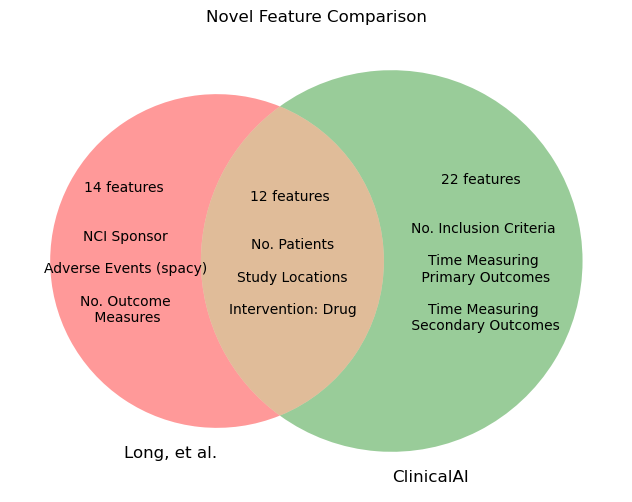

In [17]:
# venn diagram of feature comparison

# Define your two lists of strings
list1 = features_dict['long']['lymphoma']
list2 = features_dict['clinicalai']['lymphoma phase1']

# Convert lists to sets and get unique and common items
set1 = set(list1)
set2 = set(list2)
unique_to_list1 = set1 - set2
unique_to_list2 = set2 - set1
common_to_both = set1 & set2

# Create a dictionary mapping the original list elements to the desired display text
display_dict = {
    'nci_sponsor': 'NCI Sponsor\n',
    'spacy_aes_outcome': 'Adverse Events (spacy)\n',
    'num_oms': 'No. Outcome\n Measures\n',
    'num_inclusion': 'No. Inclusion Criteria\n',
    'secondary_max_days': 'Time Measuring\n Secondary Outcomes\n',
    'enroll_count': 'No. Patients\n',
    'num_locations': 'Study Locations\n',
    'drug_intervention': 'Intervention: Drug\n',
    'primary_max_days': "Time Measuring\n Primary Outcomes\n"
    # Add more mappings as needed
}

selected_unique_to_list1 = ['nci_sponsor', 'spacy_aes_outcome', 'num_oms']  # Example: manually select features
selected_unique_to_list2 = ['num_inclusion', 'primary_max_days', 'secondary_max_days']  # Example: manually select features
selected_common_to_both = ['enroll_count', 'num_locations', 'drug_intervention']

# Function to format the label with selected items and their mapped text
def format_venn_label(items, full_items):
    count = len(full_items)
    # Replace each item with its corresponding display text from the dictionary
    mapped_items = [display_dict.get(item, item) for item in items]  # Use the item if not found in dict
    first_few = "\n".join(mapped_items)  # Join the mapped items
    return f"{count} features \n\n\n{first_few}"

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2([set1, set2], set_labels=('Long, et al.', 'ClinicalAI'))

# Update each section of the Venn with the number of items and the selected items with custom text
venn.get_label_by_id('10').set_text(format_venn_label(selected_unique_to_list1, unique_to_list1))  # Unique to List 1
venn.get_label_by_id('01').set_text(format_venn_label(selected_unique_to_list2, unique_to_list2))  # Unique to List 2
venn.get_label_by_id('11').set_text(format_venn_label(selected_common_to_both, common_to_both))   # Common to both

# Display the plot
plt.title("Novel Feature Comparison")
plt.savefig(os.path.join("../figures", "0_paperfig_feature_comparison.png"))
plt.show()
